## Possibly Splitting the data train test on the months 

chat: suggested that we train one month for training and one for testing bc random could intoduce a bias when we want to keep the temporal data to keep the trends

Why? Because our data has a natural time order random train-test splitting can introduce data leakage bc the model sees future patterns during training that it shouldnt have access to (feb trends while training on Jan)  --> this then leads to inflating performance metrics making the modle look better than it actually is

In [23]:
import pandas as pd
import numpy as np
import os
from tkinter import Tk
from tkinter.filedialog import askopenfilename
import numpy as np
import lightgbm as lgb
from lightgbm import early_stopping, log_evaluation
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score
from datetime import datetime

In [24]:
# Load your dataset
print("Current working directory:", os.getcwd())

# Let user select their local file
#Tk().withdraw()  # Hide the root window
file_path = askopenfilename(title="Select your local final cleaned taxi data CSV")

# Check and load
if not file_path or not os.path.exists(file_path):
    raise FileNotFoundError("File not found or not selected.")
else:
    df = pd.read_csv(file_path)
    print("Loaded file:", file_path)
    print("Initial shape:", df.shape)
print(f"Dataset loaded successfully! Shape: {df.shape}")
print(f"Columns: {list(df.columns)}")

Current working directory: c:\diksha\Summer Sem\DataAnalysis\Notebooks
Loaded file: C:/diksha/Summer Sem/DataAnalysis/Data/cleaned/final_cleaned_jan_feb_2023_taxi_data.csv
Initial shape: (5646828, 19)
Dataset loaded successfully! Shape: (5646828, 19)
Columns: ['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'trip_distance', 'fare_amount', 'trip_duration_min', 'pickup_date', 'pickup_hour', 'pickup_day_of_week', 'pickup_borough', 'pickup_zone', 'pickup_service_zone', 'dropoff_borough', 'dropoff_zone', 'dropoff_service_zone', 'fare_per_minute', 'trip_speed', 'trip_speed_mph', 'time_of_day', 'is_weekend']


## Split by time Jan = Train, Feb = Test

In [25]:
# Convert to datetime if not already
df['pickup_date'] = pd.to_datetime(df['pickup_date'])
df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'])
df['tpep_dropoff_datetime'] = pd.to_datetime(df['tpep_dropoff_datetime'])


# Ensure your date ranges are accurate
jan_mask = df['pickup_date'].dt.month == 1
feb_mask = df['pickup_date'].dt.month == 2

train_df = df[jan_mask].copy()
test_df = df[feb_mask].copy()

print(f"Train shape: {train_df.shape}")
print(f"Test shape: {test_df.shape}")


Train shape: (2899058, 19)
Test shape: (2747770, 19)


In [26]:
#  Remove leakage features 
leakage_features = ['fare_amount', 'trip_duration_min']
target_column = 'fare_per_minute'

X_train = train_df.drop(columns=leakage_features + [target_column])
y_train = train_df[target_column]

X_test = test_df.drop(columns=leakage_features + [target_column])
y_test = test_df[target_column]

# Add target back for encoding 
X_train_full = X_train.copy()
X_train_full['fare_per_minute'] = y_train

X_test_full = X_test.copy()
X_test_full['fare_per_minute'] = y_test

# Base encoding 
def base_encode(df):
    df_encoded = df.copy()
    df_encoded['is_weekend'] = df_encoded['is_weekend'].astype(int)
    onehot_cols = ['pickup_borough', 'dropoff_borough', 'pickup_service_zone', 'dropoff_service_zone']
    df_encoded = pd.get_dummies(df_encoded, columns=onehot_cols, drop_first=True)
    time_order = {
        'Early Morning': 0, 'Morning Rush': 1, 'Midday': 2, 'Evening Rush': 3, 'Night': 4
    }
    df_encoded['time_of_day_encoded'] = df_encoded['time_of_day'].map(time_order)
    df_encoded.drop('time_of_day', axis=1, inplace=True)
    return df_encoded

#  Target Encoding 
def target_encode_train_and_apply(train_df, test_df, target_column, zone_columns):
    train_encoded = train_df.copy()
    test_encoded = test_df.copy()
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    for col in zone_columns:
        new_col = f"{col}_target_encoded"
        train_encoded[new_col] = np.nan
        for train_idx, val_idx in kf.split(train_df):
            train_fold, val_fold = train_df.iloc[train_idx], train_df.iloc[val_idx]
            means = train_fold.groupby(col)[target_column].mean()
            train_encoded.loc[val_fold.index, new_col] = val_fold[col].map(means)
        final_means = train_df.groupby(col)[target_column].mean()
        test_encoded[new_col] = test_df[col].map(final_means)
        train_encoded.drop(columns=col, inplace=True)
        test_encoded.drop(columns=col, inplace=True)
    return train_encoded, test_encoded

#  Run encoding
train_base = base_encode(X_train_full)
test_base = base_encode(X_test_full)

train_encoded, test_encoded = target_encode_train_and_apply(
    train_base, test_base,
    target_column='fare_per_minute',
    zone_columns=['pickup_zone', 'dropoff_zone']
)

#  Drop datetime columns 
for col in ['pickup_date', 'tpep_pickup_datetime', 'tpep_dropoff_datetime']:
    train_encoded.drop(columns=col, errors='ignore', inplace=True)
    test_encoded.drop(columns=col, errors='ignore', inplace=True)

## Train and Eval LightGBM

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.104670 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1349
[LightGBM] [Info] Number of data points in the train set: 2899058, number of used features: 27
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 1.275115
Training until validation scores don't improve for 10 rounds
[10]	training's l1: 0.168622	valid_1's l1: 0.165074
[20]	training's l1: 0.113063	valid_1's l1: 0.110311
[30]	training's l1: 0.0817852	valid_1's l1: 0.0794383
[40]	training's l1: 0.0635676	valid_1's l1: 0.0614893
[50]	training's l1: 0.0541568	valid_1's l1: 0.0523324
[60]	training's l1: 0.0495742	valid_1's l1: 0.0479241
[70]	training's l1: 0.0476694	valid_1's l1: 0.04615

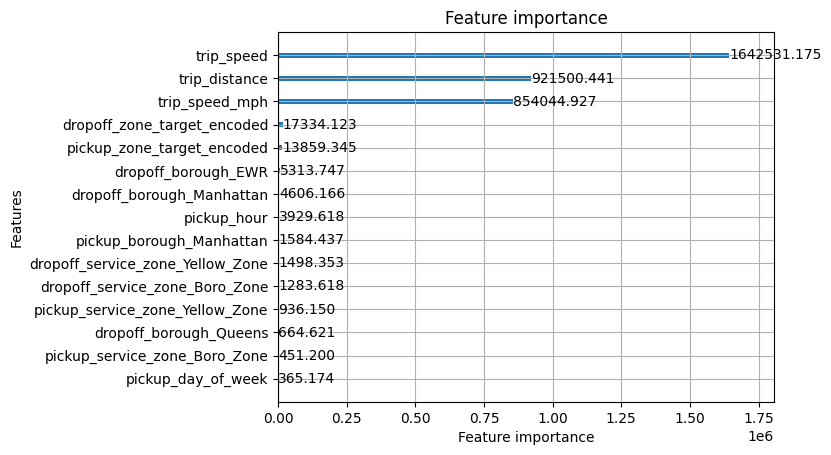

In [28]:
X_train_final = train_encoded.drop(columns='fare_per_minute')
y_train_final = train_encoded['fare_per_minute']
X_test_final = test_encoded.drop(columns='fare_per_minute')
y_test_final = test_encoded['fare_per_minute']

train_data = lgb.Dataset(X_train_final, label=y_train_final)
test_data = lgb.Dataset(X_test_final, label=y_test_final, reference=train_data)

params = {
    'objective': 'regression',
    'metric': 'mae',
    'boosting_type': 'gbdt',
    'learning_rate': 0.05,
    'feature_fraction': 0.9
}

model = lgb.train(
    params,
    train_data,
    valid_sets=[train_data, test_data],
    num_boost_round=100,
    callbacks=[early_stopping(10), log_evaluation(10)]
)

y_pred = model.predict(X_test_final)
print("MAE:", mean_absolute_error(y_test_final, y_pred))
print("R²:", r2_score(y_test_final, y_pred))
lgb.plot_importance(model, max_num_features=15, importance_type='gain');

## Discussion

1. MAE is 0.045 and Rsquared is 0.957 which is the exact same as the random_split model when we removed the leakage 

2. Though the reults are the same it would in my opinion be better to use this model over the random_split because this model mimics real-world dev by preserving time order. 

I think that since both models give a similar performance that is a strong sign that the inital model is stable and is ready to move onto a different model like random forest or XGBBoost

Further studies to do before making a new model: Feature importance to see what features are driving the model and maybe detect any leftover leakage or useless features

## Train and Eval Linear Regession

Once again for a simple baseline comparison to show how well a basic model does against a more complex model such as LightGBM or Random Forest. This could also help indicate if there is still any data leakage if it preforms unsually well, and an extra sanity check for the models (if lighgbm is only a little better than linear could mean the dataset doesnt need complex models or that more feature engin is needed)

In [32]:
# Drop NaN values from encoded data
train_encoded_clean = train_encoded.dropna()
test_encoded_clean = test_encoded.dropna()

# Align y_train and y_test accordingly
y_train_clean = y_train.loc[train_encoded_clean.index]
y_test_clean = y_test.loc[test_encoded_clean.index]

# Fit model
lr_model = LinearRegression()
lr_model.fit(train_encoded_clean, y_train_clean)

# Predict
y_pred_lr = lr_model.predict(test_encoded_clean)

# Evaluate
mae_lr = mean_absolute_error(y_test_clean, y_pred_lr)
r2_lr = r2_score(y_test_clean, y_pred_lr)

print(f"Linear Regression MAE: {mae_lr:.3f}")
print(f"Linear Regression R²:  {r2_lr:.3f}")


Linear Regression MAE: 0.000
Linear Regression R²:  1.000


## Discussion 

Yeah I am too tired rn to do a full discussion but just from a glance these results are wayyyyyy tooo good which means there is a data leak somewhere will look more later